# Resampling

In [1]:
import pyspark

from IPython.display import display
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [5]:
spark = (
    pyspark.sql.SparkSession.builder
    .master("local[*]")
    .appName("bod-seats")
    .config("spark.driver.memory", "16g")
    .getOrCreate()
)
spark

In [27]:
df = spark.read.format("parquet").load("total.parquet")
df.printSchema()
df.summary().show()
df.where(col("label") > 0).summary().show()

root
 |-- id: string (nullable = true)
 |-- label: byte (nullable = true)
 |-- text: struct (nullable = true)
 |    |-- input_ids: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- attention_mask: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- length: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |    |-- offset_mapping: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- special_tokens_mask: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- token_type_ids: array (nullable = true)
 |    |    |-- element: short (containsNull = true)

+-------+--------------------+------------------+
|summary|                  id|             label|
+-------+--------------------+------------------+
|  count|                7009|              7009|
|   mean|                null|0.5856755599942931|
| stddev|                null|1.8

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|             7009|
|   mean| 3102.64060493651|
| stddev|5388.423975393588|
|    min|                2|
|    25%|              256|
|    50%|              566|
|    75%|             2157|
|    max|            40018|
+-------+-----------------+



'zero length count: 0'

'valid length count (<= 512): 3198'

'length count: 7009'

'percent length <= 512 (max sequence length for ALBERT): 0.4562705093451277'

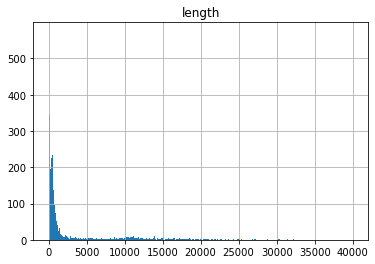

In [25]:
length = df.select(col("text.length").getItem(0).alias("length"))
length.summary().show()
display(f"zero length count: {length.where(col('length') == 0).count()}")
length.toPandas().hist(bins=1000)
valid_length_count = length.where(col('length') <= 512).count()
display(f"valid length count (<= 512): {valid_length_count}")
length_count = length.count()
display(f"length count: {length_count}")
display(f"percent length <= 512 (max sequence length for ALBERT): {valid_length_count / length_count}")

In [28]:
df = df.where(col("text.length").getItem(0) <= 512)
df.printSchema()
df.summary().show()
df.where(col("label") > 0).summary().show()

root
 |-- id: string (nullable = true)
 |-- label: byte (nullable = true)
 |-- text: struct (nullable = true)
 |    |-- input_ids: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- attention_mask: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- length: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |    |-- offset_mapping: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- special_tokens_mask: array (nullable = true)
 |    |    |-- element: short (containsNull = true)
 |    |-- token_type_ids: array (nullable = true)
 |    |    |-- element: short (containsNull = true)

+-------+--------------------+------------------+
|summary|                  id|             label|
+-------+--------------------+------------------+
|  count|                3198|              3198|
|   mean|                null|0.5100062539086929|
| stddev|                null|1.7

In [32]:
nonzero = df.where(col("label") > 0)
nz_train, nz_test = nonzero.randomSplit([.8, .2], 42)
zero = df.where(col("label") == 0)
z_train, z_test = zero.randomSplit([.8, .2], 42)
display(nz_train.count(), z_train.count())
_nz_train = nz_train
for _ in range(int(z_train.count() / nz_train.count())):
    _nz_train = _nz_train.union(nz_train)
nz_train = _nz_train
display(nz_train.count(), z_train.count())
train = nz_train.union(z_train).orderBy(rand())
test = nz_test.union(z_test).orderBy(rand())
train.summary().show()
test.summary().show()

224

2324

2464

2324

+-------+--------------------+------------------+
|summary|                  id|             label|
+-------+--------------------+------------------+
|  count|                4788|              4788|
|   mean|                null| 3.030284043441938|
| stddev|                null|3.1790325453376633|
|    min|1119_BloomEnergy_...|                 0|
|    25%|                null|                 0|
|    50%|                null|                 3|
|    75%|                null|                 5|
|    max|visioneeredimages...|                11|
+-------+--------------------+------------------+

+-------+--------------------+------------------+
|summary|                  id|             label|
+-------+--------------------+------------------+
|  count|                 650|               650|
|   mean|                null|              0.48|
| stddev|                null|1.7002854831442469|
|    min|1119_BloomEnergy_...|                 0|
|    25%|                null|                 0|

In [33]:
train.write.format("parquet").mode("overwrite").save("train.parquet")
test.write.format("parquet").mode("overwrite").save("test.parquet")